# Dropout mlp

In [132]:
from __future__ import print_function
import numpy as np
from IPython.display import clear_output
np.random.seed(42)

In [133]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__ (self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        pass
    
    def forward(self, input,mode):
        """
        Takes an input data of shape [batch,input_units], returns output data [batch,output_units]
        """
        return input

    def backward(self,input, grad_output):
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output,d_layer_d_input)

In [134]:
class ReLU(Layer):
    def __init__(self):
        pass
    def forward(self,input,mode):
        return np.maximum(0,input)
    
    def backward(self,input,grad_output):        
        relu_grad = input>0
        return grad_output*relu_grad

In [136]:
class Dense(Layer):
    def __init__(self,input_units,output_units,learning_rate=0.1,initialization='xavier'):
        """
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        if initialization == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2.0/(input_units+output_units))
        else:
            self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input,mode):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases 
    
    def backward(self,input,grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        grad_weights = np.dot(input.T,grad_output)/input.shape[0]
        grad_biases = grad_output.mean(axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate*grad_weights
        self.biases = self.biases - self.learning_rate*grad_biases
        
        return grad_input

In [137]:
class Dropout(Layer):
    def __init__(self,p):
        self.p = p
    def forward(self,input,mode):
        if mode=='test':
            return input
        self.mask = (np.random.rand(*input.shape)>=self.p)/(1-self.p)
        input = input * self.mask
        return input
    def backward(self,input,grad_output):
        return grad_output*self.mask

In [138]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return - ones_for_answers + softmax

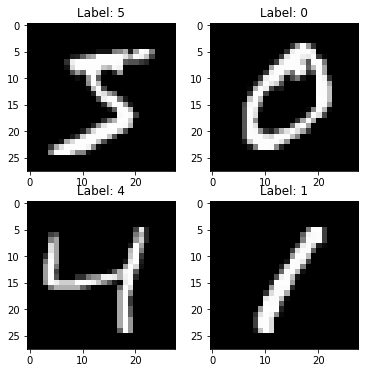

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [140]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dropout(0.8))
network.append(Dense(200,10))

In [141]:
def forward(network,X,mode):
    activations = []
    input = X
    for layer in network:
        activations.append(layer.forward(input,mode))
        input = activations[-1]
        
        
    assert len(activations) == len(network)
    return activations

def predict(network,X,mode='train'):
    logits = forward(network,X,mode)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    layer_activations = forward(network,X,mode='train')
    layer_inputs = [X]+layer_activations
    logits = layer_activations[-1]
    
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for layer_i in range(len(network))[::-1]:
        layer = network[layer_i]
        
        loss_grad = layer.backward(layer_inputs[layer_i],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

In [142]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 35
Train accuracy: 0.9909
Val accuracy: 0.974


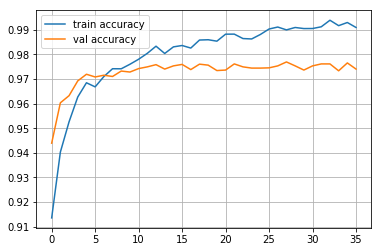

  0%|          | 0/1562 [00:00<?, ?it/s]

In [ ]:
train_log = []
val_log = []
losses = []
for epoch in range(100):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        loss = train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val,mode='test')==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [ ]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9794


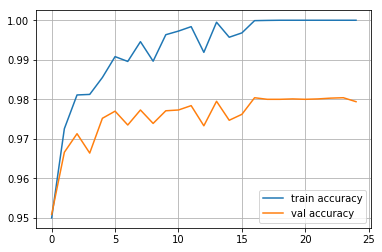

In [124]:
train_log = []
val_log = []
for epoch in range(100):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val,mode='test')==y_val))
   
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()